#### Importing the required libraries 

In [84]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

#### Reading the Datasets (Meta, Train and test)

In [110]:
base_path = 'C:/Users/gmadh/Desktop/GaTech/SUMMER 2021/ISYE 6740 Machine Learning/Project'

## Reading the meta dataset
meta_data = pd.read_csv("Data/Meta.csv")
## Getting the number of classes from the Meta dataset
classes = meta_data.shape[0]

## Loading the sample image for each class from Meta dataset
meta_img = []
meta_class = []
meta_path = f'{base_path}/Data/Meta/'
meta_files = os.listdir(meta_path)
for file in meta_files:
    '''
    Note: I am not resizing these images as I will use them for EDA purposes only.
    '''
    image = cv2.imread(meta_path+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    meta_img.append(image)
    meta_class.append(file.split('.')[0])
    
## Reading the Train data set (consists of images in multiple folders).This piece of code will iteratively read images from every folder.
'''
Two lists are populated. The raw training images are of different resolutions. They are loaded as such in train_data_raw. 
For purpose of modeling, all images are resized to a common resolution (30x30) and loaded into train_data
'''

train_data_raw = []
train_data=[]
train_labels=[]

res = 30

for c in range(classes) :
    path = f'{base_path}/Data/Train/{c}/'.format(c)
    files = os.listdir(path)
    for file in files:
        train_image = cv2.imread(path+file)
        train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(train_image, (res, res), interpolation = cv2.INTER_AREA)
        train_data.append(np.array(image_resized))
        train_data_raw.append(train_image)
        train_labels.append(c)
        
## Reading the Test data images 
test_csv = pd.read_csv(f'{base_path}/Data/Test.csv')
test_img_path = test_csv['Path']

## List containing class labels for test data
test_labels = test_csv['ClassId'].values
test_data = []  ## List to hold resized test images
test_data_raw = []  ## List to hold test images in raw format

for f in test_img_path:
    test_image = cv2.imread(f'{base_path}/Data/' + f)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(test_image, (res, res), interpolation = cv2.INTER_AREA)
    test_data.append(np.array(image_resized))
    test_data_raw.append(test_image)
    
    #from PIL import Image
    #image_from_array = Image.fromarray(image, 'RGB')
    #resized_image = np.array(image_from_array.resize((30, 30)))

#### Visualizing images representing the 43 classes in the data set

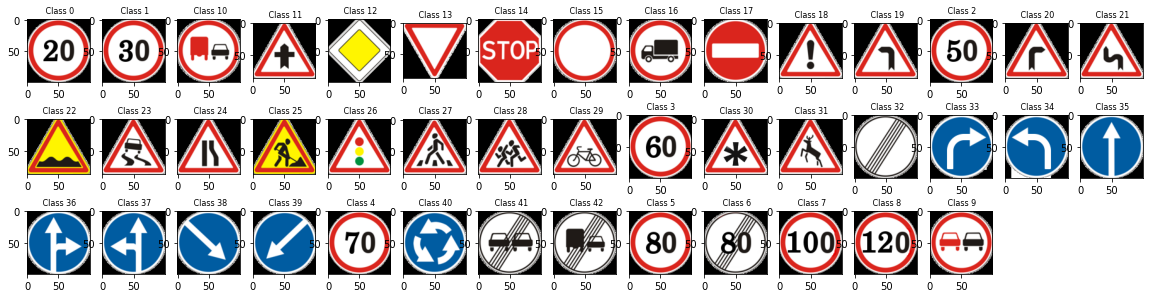

In [111]:
fig = plt.figure(figsize=(20, 5))
columns = 15
rows = 3

i=0
for c, img in zip(meta_class, meta_img):
    sp = fig.add_subplot(rows, columns, i+1)
    sp.set_title(f" Class {c}", fontdict = {'fontsize':8})
    plt.imshow(img)
    i += 1
plt.show() 
fig.tight_layout() 

#### Understanding distribution of class frequencies in both the test and train data sets

In [112]:
train_dist = dict(Counter(train_labels))
test_dist = dict(Counter(test_labels))

x_train,y_train = zip(*sorted(train_dist.items()))
x_test,y_test = zip(*sorted(test_dist.items()))

In [127]:
def class_dist(x_train, y_train, x_test, y_test, classes='all'):

    fig = plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(x_train, y_train)
    plt.axhline(y=np.average(y_train), color='r', linestyle='dashed', label="Mean")
    plt.axhline(y=np.median(y_train), color='y', linestyle='dashed', label="median")
    plt.xlabel("Class ID")
    if classes == 'all':
        plt.xticks(range(0,45,5))
    else:
        plt.xticks(range(0,7,1))
    plt.ylabel("Class Frequency")
    plt.title("Class Distribution of Training Images")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(x_test, y_test)
    plt.axhline(y=np.average(y_test), color='r', linestyle='dashed', label="Mean")
    plt.axhline(y=np.median(y_test), color='y', linestyle='dashed', label="median")
    plt.xlabel("Class ID")
    if classes == 'all':
        plt.xticks(range(0,45,5))
    else:
        plt.xticks(range(0,7,1))
    plt.ylabel("Class Frequency")
    plt.title("Class Distribution of Test Images")
    plt.legend()
    plt.show()

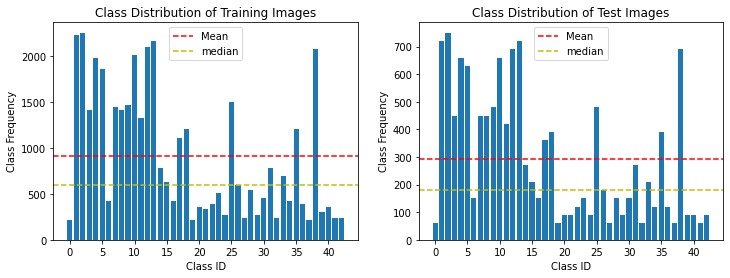

In [114]:
class_dist(x_train, y_train, x_test, y_test)

#### Both train and test data sets have around the same distribution of images for each class. There are a few classes with more images and few classes with fewer images. There is an imbalance within the dataset. This needs to be handled before modeling

In [137]:
train_pix = dict(Counter([img.shape[0]*img.shape[1]*img.shape[2] for img in train_data_raw]))
test_pix = dict(Counter([img.shape[0]*img.shape[1]*img.shape[2] for img in test_data_raw]))

pixel_range = [(1000, 3000), (3000, 6000), (6000, 9000), (9000, 12000), (12000, 15000), (15000, 18000), (18000)]

In [130]:
def pixel_dist(train_pix, test_pix, pixel_range,reduced='N'):
    pixel_dist = []

    fig = plt.figure(figsize=(15, 4))

    for tup in pixel_range:
        if isinstance(tup,int):
            pixel_dist.append(sum([v for k,v in train_pix.items() if (k >= tup)]))
        else:
            pixel_dist.append(sum([v for k,v in train_pix.items() if (k >= tup[0] and k < tup[1])]))

    plt.subplot(1, 2, 1)
    plt.bar([f'<{i[1]}' if isinstance(i,tuple) else f' >={i}' for i in pixel_range], pixel_dist)
    plt.xlabel("Pixel Range")
    plt.ylabel("Frequency of Train Images")
    
    if reduced == 'Y':
        plt.axhline(y=2700, color='r', linestyle='-', label="Common Resolution")
    plt.legend()
    plt.title("Distribution of Training Image Resolution")

    pixel_dist = []
    for tup in pixel_range:
        if isinstance(tup,int):
            pixel_dist.append(sum([v for k,v in test_pix.items() if (k >= tup)]))
        else:
            pixel_dist.append(sum([v for k,v in test_pix.items() if (k >= tup[0] and k < tup[1])]))

    plt.subplot(1, 2, 2)
    plt.bar([f'<{i[1]}' if isinstance(i,tuple) else f' >={i}' for i in pixel_range], pixel_dist)
    plt.xlabel("Pixel Range")
    plt.ylabel("Frequency of Test Images")
    if reduced == 'Y':
        plt.axhline(y=2700, color='r', linestyle='-', label="Common Resolution")
    plt.legend()
    plt.title("Distribution of Test Image Resolution")
    

    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


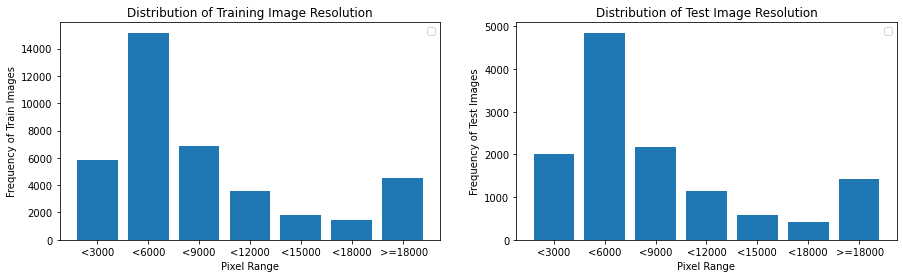

In [131]:
pixel_dist(train_pix, test_pix, pixel_range)

#### Observation : Different Image resolutions in both test and train data sets. Images have to be resized to a common resolution before modeling.

#### Performing PCA on the training images of each class to get the top 5 principal components for each class

In [138]:
k=5  ## Number of principal components
pca_res = []

for i in range(classes):
    
    data = np.array(train_data)[np.where(np.array(train_labels)==i)]
    data = data.reshape((data.shape[0], 30*30*3))
    data_scaled = data.astype(float)/255
    
    ## Fitting PCA 
    pca = PCA(n_components=k)
    X_r = pca.fit(data_scaled.T).transform(data_scaled.T)
    pca_res.append(X_r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

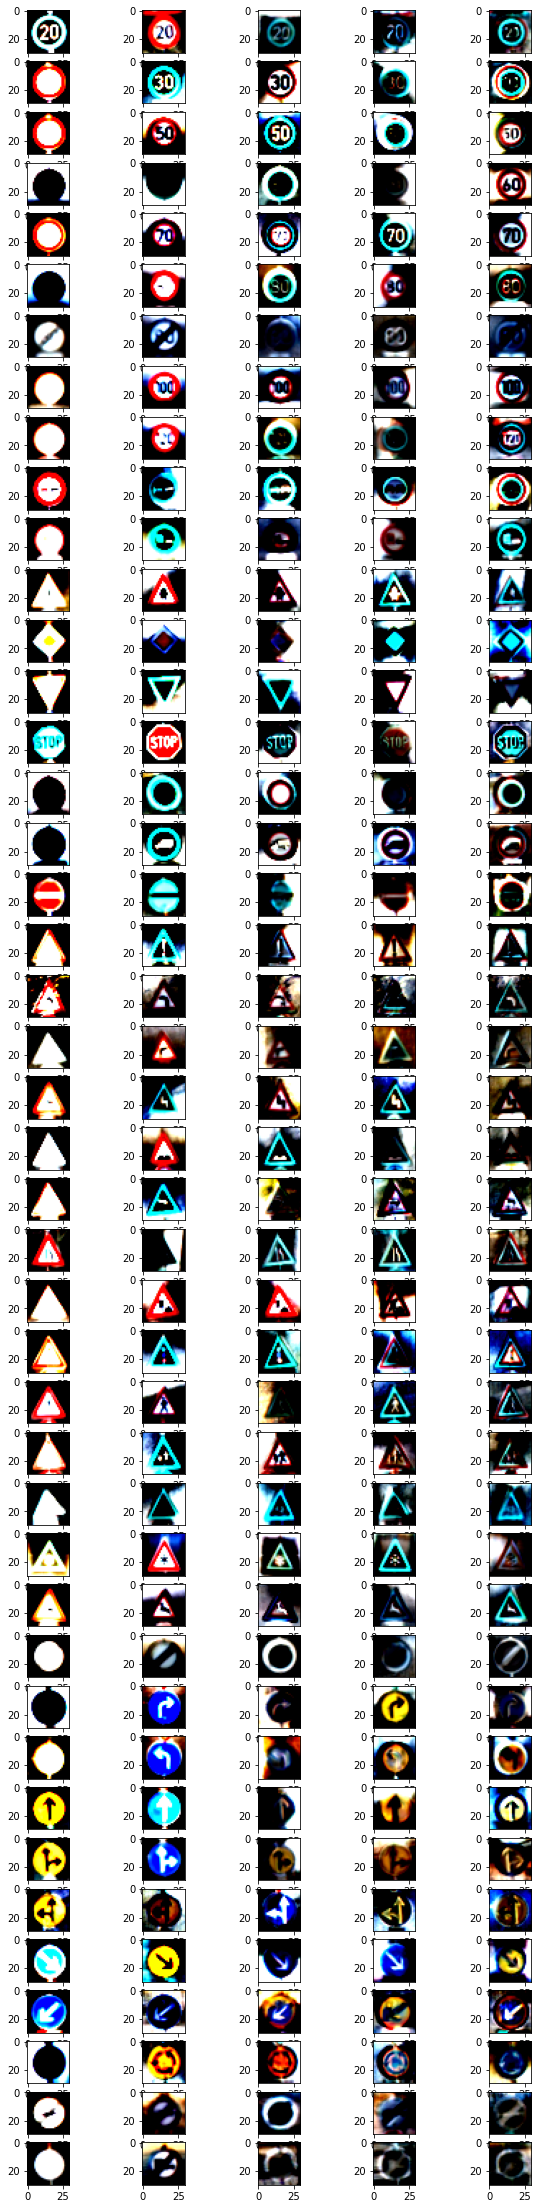

In [139]:
fig = plt.figure(figsize=(10,40))
rows = 43
columns = k

ind = 0
for i in range(classes):
    for pcs in range(k):
        plt.subplot(rows, columns, ind+1)
        plt.imshow(pca_res[i].T[pcs].reshape(30,30,3))
        ind += 1
plt.show()

#### Performing PCA and plotting the top 2 principal components for images categorized by shape and understanding patterns

In [118]:
## Creating labels based on shape of images
shape_groups = {'triangle_up':[11,18,19,20,21,22,23,24,25,26,27,28,29,30,31], 'inverted_triangle':[13], 'circle':[0,1,2,3,4,5,6,7,8,9,10,15,16,17,32,33,34,35,36,37,38,39,40,41,42], 'diamond':[12], 'octagon':[14]}
shape_group_labels = {'triangle_up':1, 'inverted_triangle':2, 'circle':3, 'diamond':4, 'octagon':5}

group_indices_train = {}

for k in shape_groups.keys():
    group_indices_train[k] = np.where(np.isin(np.array(train_labels), shape_groups[k]) == True)[0]
    
## Creating new labels for train and test datasets
train_lbl_shape_grp = np.array(train_labels)

## Updating new label values for each group
for k,v in shape_group_labels.items():  ##New group labels for shapes
    train_lbl_shape_grp[group_indices_train[k]] = v

In [119]:
k=2  ## Number of principal components
pca_res = []
shapes = list(set(train_lbl_shape_grp))

data = np.array(train_data)
data = np.mean(data, -1)
data = data.reshape((data.shape[0], 30*30))
data_scaled = data.astype(float)/255

## Fitting PCA 
pca = PCA(n_components=k)
X_r = pca.fit(data_scaled).transform(data_scaled)
pca_res.append(X_r)

#### Plotting the top 2 principal components and color coding the data points by shape

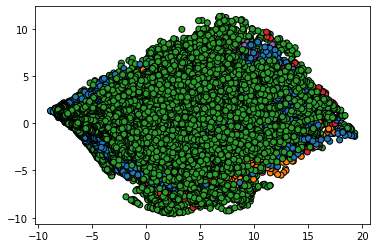

In [120]:
cm_bright = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.scatter(X_r[:,0],X_r[:,1],c=train_lbl_shape_grp, cmap=cm_bright,edgecolors='k')

#### Grouping the classes together and understanding the distribution and PCA's

In [121]:
## Creating groups of classes and getting indexes of group elements from test and train datatsets.
groups = {'speed':[0,1,2,3,4,5,7,8], 'prohibitory':[9,10,15,16], 'derestriction':[6,32,41,42], 'mandatory':[33,34,35,36,37,38,39,40], 'danger':[11,18,19,20,21,22,23,24,25,26,27,28,29,30,31], 'other':[12,14,13,17]}
group_labels = {'speed':1, 'prohibitory':2, 'derestriction':3, 'mandatory':4, 'danger':5, 'other':6}

group_indices_train = {}
group_indices_test = {}

for k in groups.keys():
    group_indices_train[k] = np.where(np.isin(np.array(train_labels), groups[k]) == True)[0]
    group_indices_test[k] = np.where(np.isin(np.array(test_labels), groups[k]) == True)[0]
    
## Creating new labels for train and test datasets
train_lbl_grp = np.array(train_labels)
test_lbl_grp = np.array(test_labels)

## Updating new label values for each group
for k,v in group_labels.items():  ##New group labels
    train_lbl_grp[group_indices_train[k]] = v
    test_lbl_grp[group_indices_test[k]] = v

#### Distribution of classes after grouping

In [122]:
train_dist = dict(Counter(train_lbl_grp))
test_dist = dict(Counter(test_lbl_grp))

x_train,y_train = zip(*sorted(train_dist.items()))
x_test,y_test = zip(*sorted(test_dist.items()))

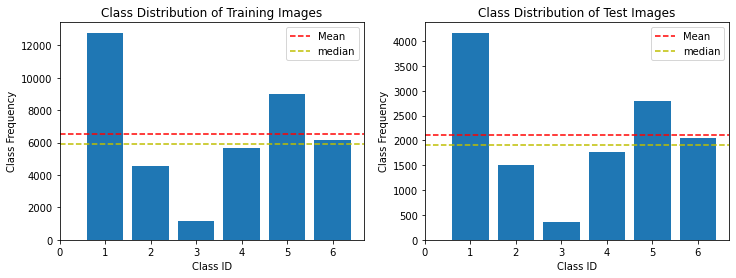

In [128]:
class_dist(x_train, y_train, x_test, y_test, 'groups')

#### Some imbalance still exists (Class 3 has very small number of images)

#### Pixel size after grouping

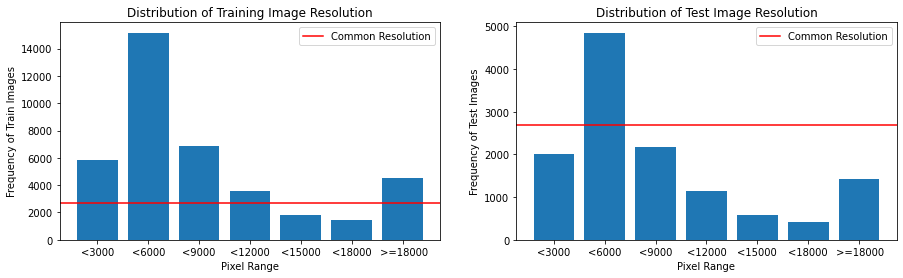

In [132]:
pixel_dist(train_pix, test_pix, pixel_range, 'Y')

#### Performing PCA for the new grouped class

In [133]:
k=5  ## Number of principal components
pca_res = []
classes_new = len(group_labels)

for i in range(1,classes_new+1):
    data = np.array(train_data)[np.where(np.array(train_lbl_grp)==i)]
    data = data.reshape((data.shape[0], 30*30*3))
    data_scaled = data.astype(float)/255
    
    ## Fitting PCA 
    pca = PCA(n_components=k)
    X_r = pca.fit(data_scaled.T).transform(data_scaled.T)
    pca_res.append(X_r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

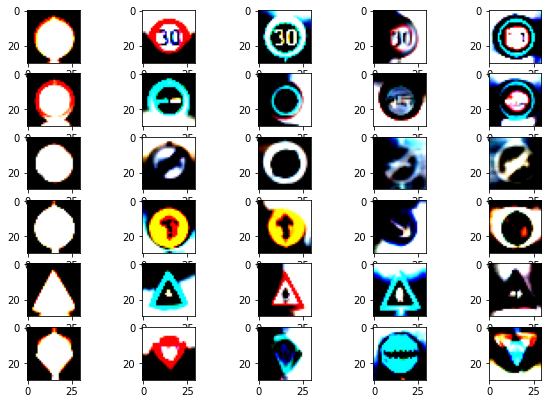

In [134]:
fig = plt.figure(figsize=(10,50))
rows = 43
columns = k

ind = 0
for i in range(classes_new):
    for pcs in range(k):
        plt.subplot(rows, columns, ind+1)
        plt.imshow(pca_res[i].T[pcs].reshape(30,30,3))
        ind += 1
plt.show()

### END of EDA

#### Exporting Data - Train

In [91]:
train_arr = np.array(train_data)
train_arr = train_arr.reshape((train_arr.shape[0], 30*30*3))
train_data_scaled = train_arr.astype(float)/255

In [92]:
## Getting original labels(43 classes) and appending with train dataset( reduced to 30 * 30 * 3 and scaled (/255))
lbl_orig = np.reshape(np.array(train_labels),(1, np.array(train_labels).size))
lbl_orig = lbl_orig.T
train_orig = np.concatenate((train_data_scaled, lbl_orig), axis=1)

In [94]:
## Getting grouped labels(6 classes) and appending with train dataset( reduced to 30 * 30 * 3 and scaled (/255))
lbl_grp = np.reshape(np.array(train_lbl_grp),(1, np.array(train_lbl_grp).size))
lbl_grp = lbl_grp.T
train_grp = np.concatenate((train_data_scaled, lbl_grp), axis=1)

In [93]:
np.savetxt('output.csv',train_orig,delimiter=",")

In [102]:
np.savetxt('output.csv',train_grp,delimiter=",")

#### Exporting Data - Test

In [104]:
test_arr = np.array(test_data)
test_arr = test_arr.reshape((test_arr.shape[0], 30*30*3))
test_data_scaled = test_arr.astype(float)/255

In [106]:
## Getting original labels(43 classes) and appending with test dataset( reduced to 30 * 30 * 3 and scaled (/255))
lbl_orig = np.reshape(np.array(test_labels),(1, np.array(test_labels).size))
lbl_orig = lbl_orig.T
test_orig = np.concatenate((test_data_scaled, lbl_orig), axis=1)

In [107]:
## Getting grouped labels(6 classes) and appending with test dataset( reduced to 30 * 30 * 3 and scaled (/255))
lbl_grp = np.reshape(np.array(test_lbl_grp),(1, np.array(test_lbl_grp).size))
lbl_grp = lbl_grp.T
test_grp = np.concatenate((test_data_scaled, lbl_grp), axis=1)

In [108]:
np.savetxt('output.csv',test_orig,delimiter=",")

In [111]:
np.savetxt('output.csv',test_grp,delimiter=",")

In [113]:
test_orig.shape

(12630, 2701)